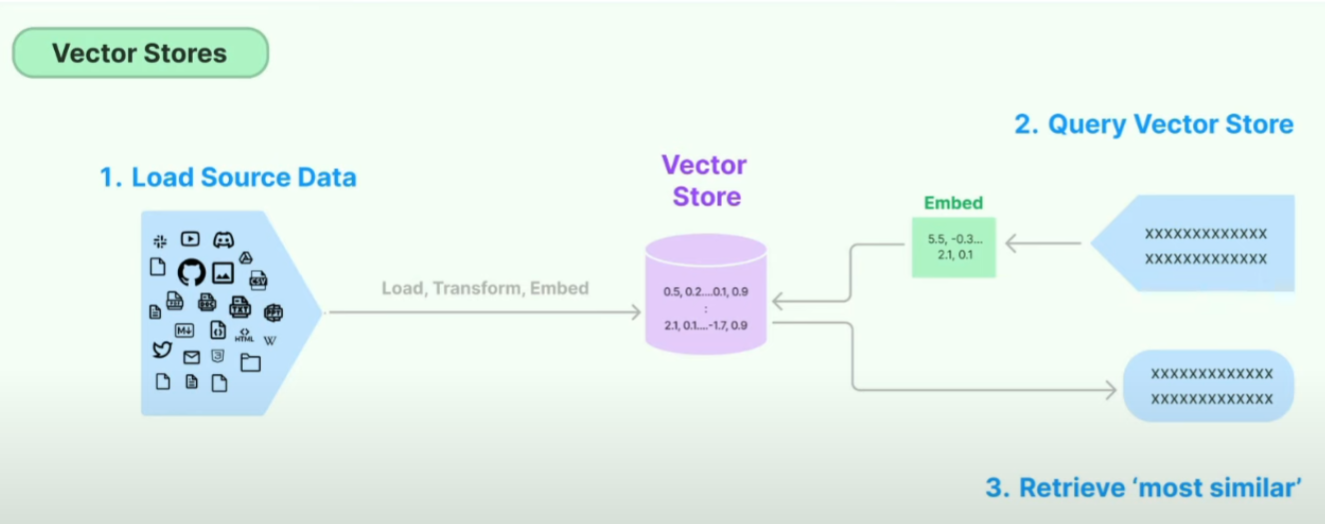

# breakdown on the operations
- load - pypdf for loading the documents
- transform - split the dataset into chunks 
- embed - convert all these chunks to vectors 
- all the vectors are stored in vector store database

In [12]:
from langchain_community.document_loaders import PyPDFLoader
from dotenv import load_dotenv
from openai import AzureOpenAI
import chromadb
import os

In [3]:
loader=PyPDFLoader('resources/books/Resume2024.pdf')
docs=loader.load()
print(docs)

[Document(metadata={'source': 'resources/books/Resume2024.pdf', 'page': 0}, page_content='AMRUTH PAI THUKARAM  \nDallas, TX, United States  \n469 -465 -4829         amruthpaiuni@gmail.com         linkedin.com/in/amruthpai         github.com/Immortal -Pi \n  \nUniversity of Texas at Dallas           Aug 2024 - May  2026  \nMaster of Science in Business Analytics  & AI  \nCoursework:  Analytics with R, Advance Statistic s, Database Foundation, Data Visualization      Dallas, Texas  \nNitte Meenakshi Institute of Technology            Aug 201 5 - Aug 2019  \nBachelor of Science in Computer Science  and Engineering  \nCoursework: Statistics, Python Programming, Machine Learning, Software Engineering                Bangalore, India  \n \n     Languages : Python, R,  JAVA, IBM DB2/SQL, RPGLE/CLLE  \n     Tools & Technologies/Frameworks : VS Code, MS-Excel, Tableau, Hugging Face , LangChain , GitHub, Git  \n     Algorithms & Models : Random Forest, Time Series Analysis, Logistic Regression, U

In [4]:
print(f'load enviroment varaibles: {load_dotenv()}')
os.environ['AZURE_OPENAI_API_KEY']=os.getenv('AZURE_OPENAI_API_KEY')

load enviroment varaibles: True


## transform
- convert the data into chunks

In [11]:
load_dotenv()
azure_client=AzureOpenAI(
    api_key=os.getenv('AZURE_OPENAI_API_KEY'),
    api_version=os.getenv('AZURE_OpenAI_API_VERSION'),
    azure_endpoint=os.getenv('AZURE_OPENAI_EMBEDDINGS_ENDPOINT')
)

In [10]:
from langchain.text_splitter import RecursiveCharacterTextSplitter
text_splitter=RecursiveCharacterTextSplitter(
    
    chunk_size=100,
    chunk_overlap=30,
)
chunks=text_splitter.split_documents(docs)

In [13]:
docs=[]
metadatas=[]
ids=[]
embeddings=[]
str=''
for index,chunk in enumerate(chunks):
    str+=f'{index}:{chunk},\n'
    response=azure_client.embeddings.create(
        input=str,
        model=os.getenv('AZURE_OPENAI_EMBEDDING_MODEL_NAME')
    )
    embeddings.append(response.data[0].embedding)
    docs.append(str)
    metadatas.append({'source':'files'})
    ids.append(f'id{index}')
    


In [16]:
chroma_client=chromadb.PersistentClient(path='resources/chroma')
collection=chroma_client.get_or_create_collection(name='files')
collection.add(
    documents=docs,
    metadatas=metadatas,
    embeddings=embeddings,
    ids=ids
)


In [17]:
collection.count()

70

# embed
- convert the texts into embeddings

In [6]:
import chromadb
from openai import AzureOpenAI
import os
from dotenv import load_dotenv
chroma_client=chromadb.PersistentClient(path='resources/chroma')

In [10]:
vectordb=chroma_client.get_collection(name='Resume2024.pdf')

In [7]:
load_dotenv()
azure_client=AzureOpenAI(
    api_key=os.getenv('AZURE_OPENAI_API_KEY'),
    api_version=os.getenv('AZURE_OpenAI_API_VERSION'),
    azure_endpoint=os.getenv('AZURE_OPENAI_EMBEDDINGS_ENDPOINT')
)

In [34]:
query_texts='does he have data science projects?'
response=azure_client.embeddings.create(
    input=query_texts,
    model='text-embedding-ada-002'
)
query_embeddings=response.data[0].embedding

In [35]:
result=collection.query(
    query_embeddings=query_embeddings,
    n_results=1
)
result

{'ids': [['id41']],
 'distances': [[0.5009397892039074]],
 'metadatas': [[{'source': 'files'}]],
 'embeddings': None,
 'documents': [["0:page_content='AMRUTH PAI THUKARAM  \nDallas, TX, United States' metadata={'source': 'resources/books/Resume2024.pdf', 'page': 0},\n1:page_content='469 -465 -4829         amruthpaiuni@gmail.com         linkedin.com/in/amruthpai' metadata={'source': 'resources/books/Resume2024.pdf', 'page': 0},\n2:page_content='github.com/Immortal -Pi' metadata={'source': 'resources/books/Resume2024.pdf', 'page': 0},\n3:page_content='University of Texas at Dallas           Aug 2024 - May  2026' metadata={'source': 'resources/books/Resume2024.pdf', 'page': 0},\n4:page_content='Master of Science in Business Analytics  & AI' metadata={'source': 'resources/books/Resume2024.pdf', 'page': 0},\n5:page_content='Coursework:  Analytics with R, Advance Statistic s, Database Foundation, Data Visualization' metadata={'source': 'resources/books/Resume2024.pdf', 'page': 0},\n6:page_co

In [36]:
system_role = "You will recieve the user's question along with the search results of that question over a database. Give the user the proper answer."
prompt = f"User's question: {query_texts} \n\n Search results:\n {result}"

message=[
    {
        'role':'system','content':system_role
    },
    {
        'role':'user','content':prompt
    }
]

In [37]:
llm=AzureOpenAI(
    api_version=os.getenv('AZURE_OpenAI_API_VERSION'),
    azure_endpoint=os.getenv('AZURE_OpenAI_ENDPOINT'),
    api_key=os.getenv('AZURE_OPENAI_API_KEY')
)
response=llm.chat.completions.create(
    model=os.getenv('AZURE_OPENAI_DEPLOYMENT_MODEL'),
    messages=message
)


In [38]:
response.choices[0].message.content

'Yes, he does have data science projects. Here are some projects and skills mentioned in the search results:\n\n1. Coursework: Analytics with R, Advance Statistics, Database Foundation, Data Visualization\n2. Data Visualization project in Dallas, Texas\n3. Certifications: IBM Professional Data Science, DeepLearning.AI TensorFlow Developer, IBM AI Engineer\n4. Algorithms & Models: Random Forest, Time Series Analysis, Logistic Regression, U-Net, Decision Tree\n5. Tools & Technologies/Frameworks: VS Code, MS-Excel, Tableau, Hugging Face, LangChain, GitHub, Git\n\nThese are just a few highlights. He also has experience in various programming languages and technologies related to data science.'